# **QLS - Project**
## **Unsupervised learning by competing hidden units**

# Libraries

In [ ]:
!pip install torchmetrics
!pip install skorch

     |████████████████████████████████| 396 kB 5.1 MB/s 
     |████████████████████████████████| 155 kB 5.1 MB/s 


In [ ]:
import numpy as np
import random
import time

import matplotlib.pyplot as plt
import seaborn as sn
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler 

import torchvision
from torchvision import transforms

from sklearn.metrics import confusion_matrix

import skorch
from skorch import NeuralNetClassifier
from skorch.dataset import ValidSplit

# Dataset

In [ ]:
'''
transforms.ToTensor convert train_dataset that is a torchvision.datasets.mnist.MNIST,
while instead train_dataloader is a Tensor.
'''

data_dir = 'dataset'
transform = transforms.Compose([transforms.ToTensor()]) 

train_dataset = torchvision.datasets.MNIST(data_dir, train=True,  download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transform)

batch_size = 128
train_split = 0.84  # circa 50040 (50000) mentioned in the paper

random_seed = 42
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor((1-train_split)* dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_dataloader      = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, shuffle=False)
validation_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler, shuffle=False)
test_dataloader       = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



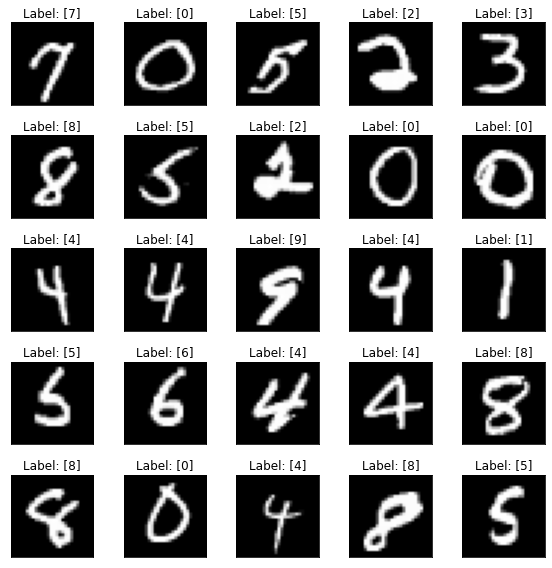

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
  
    img, label = random.choice(train_dataset) 
    ax.imshow(torch.squeeze(img), cmap='gist_gray')

    ax.set_title(f'Label: [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

# Visualizing the steps

SAMPLE AT INDEX 8000
LABEL: 0


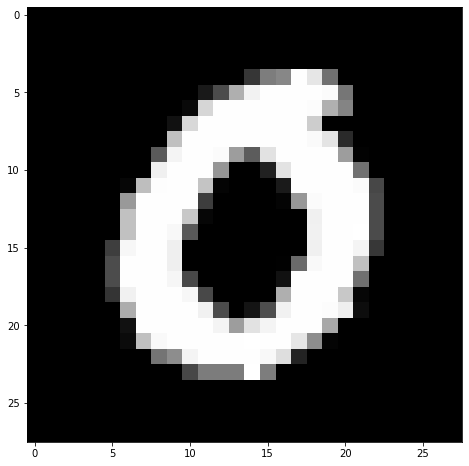

In [ ]:
sample_index = 8000

def plot_sample(sample_index):
  image = train_dataset[sample_index][0]
  label = train_dataset[sample_index][1]
  fig = plt.figure(figsize=(8,8)) 
  plt.imshow(torch.squeeze(image),cmap="Greys_r")
  print(f"SAMPLE AT INDEX {sample_index}")
  print(f"LABEL: {label}")

num_classes = 10
plot_sample(sample_index)

image = train_dataset[sample_index][0]
neurons_input = image.shape[1]**2
neurons_output = 484                     
n_synapsis = neurons_input*neurons_output

## $h$ - ODE

In [ ]:
Imat = np.ones(neurons_output) - np.identity(neurons_output) #useful matrix

#---Solution 1° ODE---
def hsteady(h_steady, Isq):
  h = np.zeros((neurons_output,lt))
  h[:,0] = h_steady
  dt11_tau = dt1/tau
  dt12_tau = dt12/tau
  for i in range(1,lt1):
    Smu = np.matmul( Imat, np.maximum(h[:,i-1], 0) )
    h[:,i] = h[:,i-1]*(1-dt11_tau) + ( Isq - winh*Smu)*dt11_tau

  for i in range(lt1,lt12+lt1):
    Smu = np.matmul( Imat, np.maximum(h[:,i-1], 0) )
    h[:,i] = h[:,i-1]*(1-dt12_tau) + ( Isq - winh*Smu)*dt12_tau
              
  return h[:,-1] , h

#---Solution 1° ODE---
def hsteady_quick(hnew, Isq):
  dt11_tau = dt1/tau
  dt12_tau = dt12/tau
  for i in range(1,lt1):
    Smu = np.matmul( Imat, np.maximum(hnew, 0) )
    hnew = hnew*(1-dt11_tau) + ( Isq - winh*Smu)*dt11_tau

  for i in range(1,lt12):
    Smu = np.matmul( Imat, np.maximum(hnew, 0) )
    hnew = hnew*(1-dt12_tau) + ( Isq - winh*Smu)*dt12_tau
           
  return hnew

In [ ]:
#---Parameters 1° ODE---
tau    = 0.05

#--1° part
tmax1  = 0.05
dt1    = 0.0005
t1     = np.arange(0,tmax1,dt1)/tau
lt1    = len(t1)

#--2° part
tmax12 = 0.6   
dt12   = 0.0010
t12    = np.arange(tmax1,tmax12,dt12)/tau
lt12   = len(t12)

tt=np.concatenate([t1, t12])
lt=len(tt)

winh   = 0.8   
h_star = 3

np.random.seed(2347)
h_steady = np.zeros(neurons_output)
W = np.random.rand( neurons_output, neurons_input) #gaussian initialization as mentioned in the paper
v = torch.flatten(image).unsqueeze(dim=1).numpy()
I = np.matmul(W,v)

t = time.time()
h_steady, h = hsteady(h_steady, np.squeeze(I))
print('1° ODE solved in: ',np.round(time.time() - t,3),'s')

frac_pos = np.sum(h_steady>0)/neurons_output
print('Winh give positive fraction of:',np.round(frac_pos*100,2),'%')

1° ODE solved in:  0.093 s
Winh give positive fraction of: 3.93 %


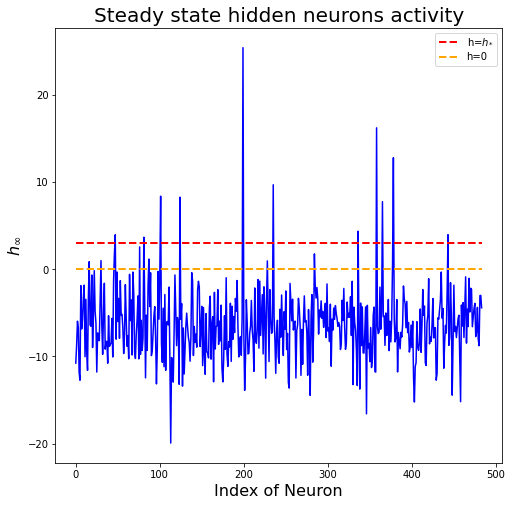

In [ ]:
#---Plot post-synaptic steady state activations ---
fig = plt.figure(figsize=(8,8))
plt.plot(np.arange(neurons_output), h_steady,'b')
plt.plot(np.arange(neurons_output), np.ones(neurons_output)*h_star,'r--',label='h=$h_{*}$',linewidth=2)
plt.plot(np.arange(neurons_output), np.zeros(neurons_output),'orange',linestyle='--', label='h=0',linewidth=2)
plt.title('Steady state hidden neurons activity',fontsize=20)
plt.xlabel('Index of Neuron',fontsize=16)
plt.ylabel('$h_{\infty}$',fontsize=16)
plt.legend()
plt.show()

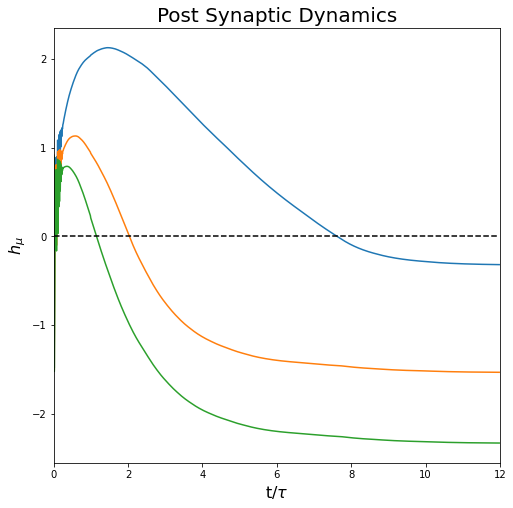

In [ ]:
#---Plot some post-synaptic activations ---
fig = plt.figure(figsize=(8,8))
plt.plot(tt,h[435,:], tt,h[446,:], tt,h[413,:])
plt.plot(tt,np.zeros(lt1+lt12),'k--')
plt.xlim((0,tmax12/tau))
plt.title('Post Synaptic Dynamics',fontsize=20)
plt.xlabel('t/$\\tau$',fontsize=16)
plt.ylabel('$h_\mu$',fontsize=16)
plt.show()

## $W_{\mu,i}$ - ODE

In [ ]:
#---Activation Function
def g(h_steady, h_star, delta):
  gh = np.ones((len(h_steady),1))*delta
  gh[h_steady >= h_star] = 1
  gh[h_steady < 0] = 0
  return gh

In [ ]:
def W_update(ghp,vp,Wp):
  Wnew = np.zeros((neurons_output,neurons_input))

  conv = np.zeros((neurons_output,lt2))
  conv[:,0]=np.sum(W**2,axis=1)

  dt2_tau = dt2/tauL
  ghv  = (ghp*vp.T)*dt2_tau

  for j in range(1,lt2):
    Iw = np.matmul(Wp,vp)
    #Corr = np.broadcast_to(ghp*Iw, (neurons_output,neurons_input)) #ghp*Iw is product-wise operation

    Corr = np.matmul(ghp*Iw,np.ones((1,neurons_input)))  

    Wp = Wp + ghv - Corr*Wp*dt2_tau     
    conv[:,j] = np.sum(Wp**2,axis=1) #comment this line to speed up training loop
 
  return Wp, conv

def W_update_quick(ghp,vp,Wp):
  Wnew = np.zeros((neurons_output,neurons_input))
  dt2_tau = dt2/tauL
  ghv  = (ghp*vp.T)*dt2_tau

  for j in range(1,lt2):
    Iw = np.matmul(Wp,vp)
    #Corr = np.broadcast_to(ghp*Iw, (neurons_output,neurons_input))
    Corr = np.matmul(ghp*Iw,np.ones((1,neurons_input))) 
    Wp = Wp + ghv - Corr*Wp*dt2_tau      

  return Wp

In [ ]:
#---Parameters 2° ODE---
delta  = -0.01    
t = time.time()
gh = g(h_steady, h_star, delta)
print('Activation applied in: ',np.round(time.time() - t,3),'s')

tauL = 5

tmax2 = 1.8
dt2 = 0.01
t2 = np.arange(0,tmax2,dt2)/tauL
lt2 = len(t2)

t = time.time()
W_new, conv = W_update(gh, v, W)
print('2° ODE solved in: ',np.round(time.time() - t,3),'s')

Activation applied in:  0.002 s
2° ODE solved in:  1.372 s


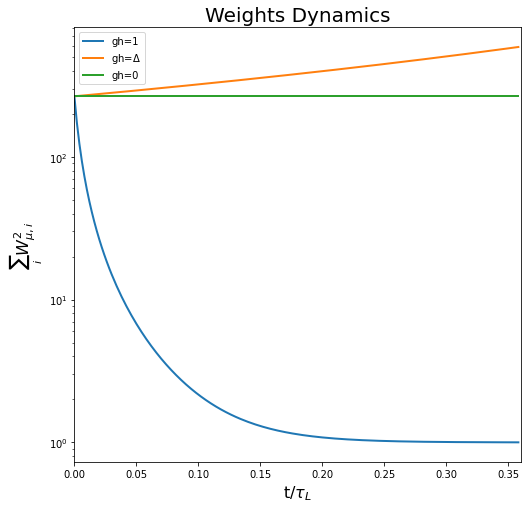

In [ ]:
#--- Sample some weight dynamics
w1 = np.random.choice(np.argwhere(gh==1)[:,0])
wd = np.random.choice(np.argwhere(gh==delta)[:,0])
w0 = np.random.choice(np.argwhere(gh==0)[:,0])

#---Plot some weights dyanmics ---
fig = plt.figure(figsize=(8,8))
plt.plot(t2,conv[w1],label='gh=1', linewidth=2)
plt.plot(t2,conv[wd],label='gh=$\Delta$', linewidth=2)
plt.plot(t2,conv[w0],label='gh=0', linewidth=2)
plt.yscale('log')
plt.xlim((0,tmax2/tauL))
plt.xlabel('t/$\\tau_L$',fontsize=16)
plt.ylabel('$\sum_{i} W_{\mu,i}^2$',fontsize=16)
plt.title('Weights Dynamics',fontsize=20)
plt.legend()
plt.show()

# Unsupervised Phase

In [ ]:
#---Hyperparameters
winh = 0.7  
h_star = 3
delta = -0.01

#---Dynamics of post-synaptic activities
tau = 0.05
#--1° part
tmax1 = 0.05
dt1 = 0.0005
t1 = np.arange(0,tmax1,dt1)/tau
lt1 = len(t1)

#--2° part
tmax12 = 0.6   
dt12 = 0.002
t12 = np.arange(tmax1,tmax12,dt12)/tau
lt12 = len(t12)

#---Dynamics of weights update
tauL = 5
tmax2 = 1.8
dt2 = 0.01
t2 = np.arange(0,tmax2,dt2)
lt2 = len(t2)

#---Initialization
h_steady = np.zeros(neurons_output)
np.random.seed(2347)
W_first = np.random.rand( neurons_output, neurons_input) 
W = W_first

#---Training
max_samples = 600   #1% of the dataset
np.random.seed(2347)
sample_indexs = np.random.randint(0, dataset_size-1, max_samples)

In [ ]:
s0=np.random.choice(np.argwhere(train_dataset.targets==0)[0],60)
s1=np.random.choice(np.argwhere(train_dataset.targets==1)[0],60)
s2=np.random.choice(np.argwhere(train_dataset.targets==2)[0],60)
s3=np.random.choice(np.argwhere(train_dataset.targets==3)[0],60)
s4=np.random.choice(np.argwhere(train_dataset.targets==4)[0],60)
s5=np.random.choice(np.argwhere(train_dataset.targets==5)[0],60)
s6=np.random.choice(np.argwhere(train_dataset.targets==6)[0],60)
s7=np.random.choice(np.argwhere(train_dataset.targets==7)[0],60)
s8=np.random.choice(np.argwhere(train_dataset.targets==8)[0],60)
s9=np.random.choice(np.argwhere(train_dataset.targets==9)[0],60)
sample_indexs = np.concatenate([s0, s1, s2, s3, s4, s5, s6, s7, s8, s9])
sample_indexs = np.random.permutation(sample_indexs)

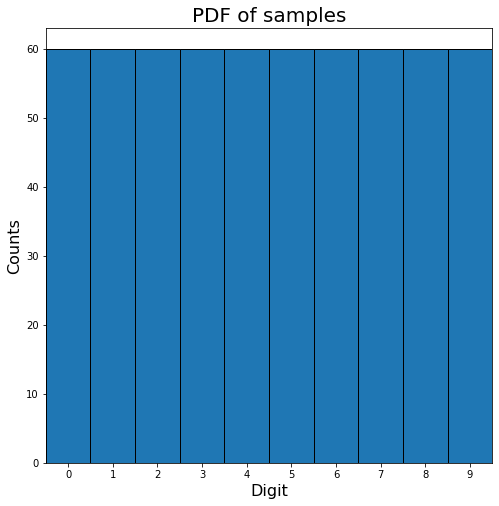

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.hist(train_dataset.targets[sample_indexs], bins=np.arange(-0.5,10.5,1), edgecolor="k")
plt.xlim((-0.5,9.5))
plt.xticks(np.arange(0,10,1))
plt.title('PDF of samples',fontsize=20)
plt.xlabel('Digit',fontsize=16)
plt.ylabel('Counts',fontsize=16)
plt.show()

In [ ]:
t = time.time()
for sample_index in tqdm(sample_indexs):

  #extract sample from the dataset
  image = train_dataset[sample_index][0]

  #steady state activation
  v = torch.flatten(image).unsqueeze(dim=1).numpy()
  I = np.matmul(W,v).squeeze()
  h_steady = hsteady_quick(h_steady,I)

  #non linear learning activation g
  gh = g(h_steady, h_star, delta)

  #update of W
  W = W_update_quick(gh, v, W)


weight_divergence = np.sum(np.abs(W_first-W))/n_synapsis  

print('\n',max_samples, ' images processed in: ',np.around(time.time() - t,3),'s')
print('\n','weight divergence: ', weight_divergence)

100%|██████████| 600/600 [09:44<00:00,  1.03it/s]


 600  images processed in:  584.947 s

 weight divergence:  0.4820124462608919


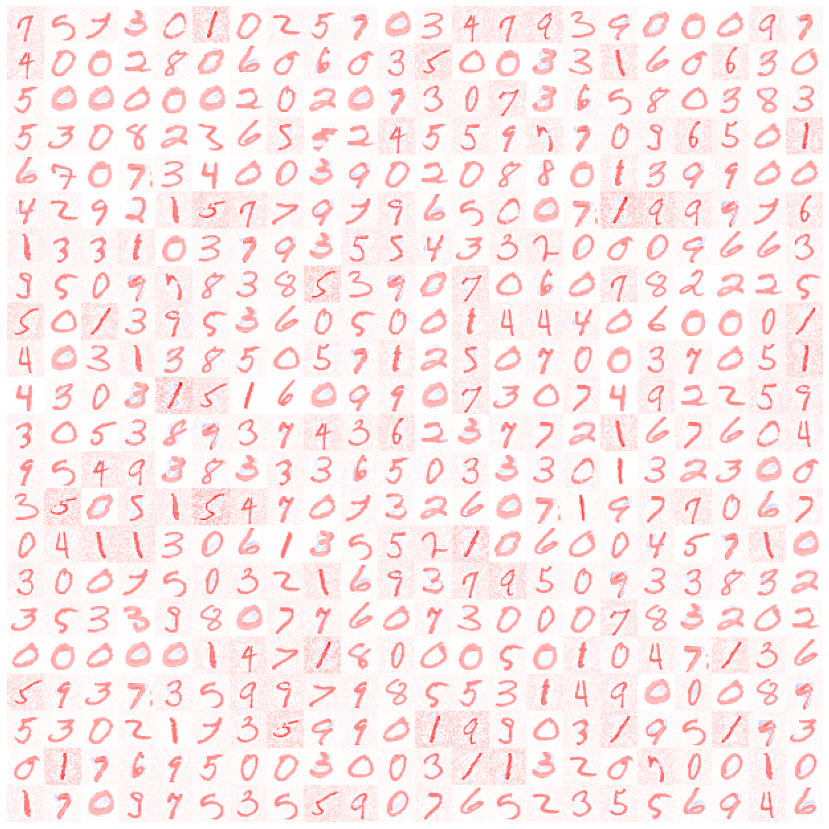

In [ ]:
def draw_weights(synapses, Kx, Ky, img_shape):
    yy=0
    HM=np.zeros((img_shape*Ky,img_shape*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*img_shape:(y+1)*img_shape,x*img_shape:(x+1)*img_shape]=synapses[yy,:].reshape(img_shape,img_shape)
            yy += 1

    fig = plt.figure(figsize=(15,15))
    plt.clf()

    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)

    #fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    plt.show()

K = 22
draw_weights(W, K, K, 28) 

# Supervised Phase

In [ ]:
class Net(nn.Module):
    
    def __init__(self, Nh1, Nh2, Nh3):
        """
        Nh1 - Neurons in the input  layer
        Nh2 - Neurons in the hidden layer
        Nh3 - Neurons in the output layer
        """
        super().__init__()
        
        print('Network initialized')
        self.f0 = nn.Flatten()
        with torch.no_grad():
          self.f1 = nn.Linear(in_features=Nh1,  out_features=Nh2, bias=False)
        self.f2 = nn.Linear(in_features=Nh2,  out_features=Nh3, bias=True)
        self.act = nn.Sigmoid()
        
    def forward(self, x, additional_out=False):
        x = self.f0(x)
        x = self.f1(x)
        x = self.f2(x)
        x = self.act(x)
        return x

In [ ]:
#---Initialize the network
torch.manual_seed(0)
Nh1 = neurons_input
Nh2 = neurons_output
Nh3 = num_classes
net1 = Net(Nh1, Nh2, Nh3)

#---Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

net1.to(device) 

#---Freeze the first layer 
with torch.no_grad():
    net1.f1.weight.copy_(torch.tensor(W))
torch.save(net1.state_dict(), 'tmp.pth')
net1.f1.weight.requires_grad = False

Network initialized
Training device: cpu


In [ ]:
K_fold = 5
max_epochs = 40
nn_final = NeuralNetClassifier(module=net1, max_epochs=max_epochs, lr=0.005, 
                               train_split=ValidSplit(K_fold), optimizer=optim.SGD, criterion=torch.nn.CrossEntropyLoss,
                               iterator_train__shuffle=True)

c = nn_final.get_iterator(train_dataloader.dataset)
nn_final.fit(c.dataset,y=None)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0076       0.7370        1.8701  9.6089
      2        1.8364       0.7742        1.8049  6.9211
      3        1.7907       0.7864        1.7732  6.7142
      4        1.7661       0.7808        1.7534  6.7178
      5        1.7502       0.7834        1.7401  6.9461
      6        1.7387       0.7903        1.7307  7.0085
      7        1.7298       0.7942        1.7230  7.0542
      8        1.7226       0.7982        1.7163  6.7059
      9        1.7167       0.7991        1.7104  6.8096
     10        1.7116       0.7991        1.7054  6.5703
     11        1.7072       0.8002        1.7014  6.8456
     12        1.7032       0.8087        1.6976  6.8029
     13        1.6997       0.8069        1.6950  6.8696
     14        1.6967       0.8080        1.6918  6.7986
     15        1.6937       0.8105        1.6881  6.8720
     16        1.6912       0.8

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (f0): Flatten(start_dim=1, end_dim=-1)
    (f1): Linear(in_features=784, out_features=484, bias=False)
    (f2): Linear(in_features=484, out_features=10, bias=True)
    (act): Sigmoid()
  ),
)

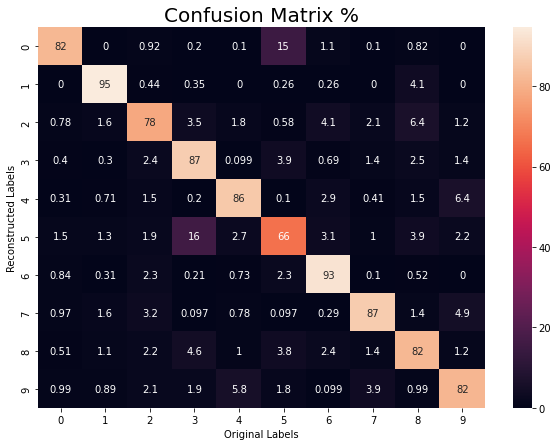

Final Test Accuray:  83.93 %


In [ ]:
d = nn_final.get_iterator(test_dataloader.dataset)
y_pred = nn_final.predict(d.dataset)
CM= confusion_matrix(d.dataset.targets.cpu().numpy(), y_pred, labels=np.arange(10))

plt.figure(figsize = (10,7))
cm = CM
cmn = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sn.heatmap(cmn, annot=True, xticklabels=np.arange(0,num_classes), yticklabels=np.arange(0,num_classes))
plt.title('Confusion Matrix %',fontsize=20)
plt.xlabel('Original Labels')
plt.ylabel('Reconstructed Labels')
plt.show()

print('Final Test Accuray: ',np.round(100*cm.diagonal().sum()/cm.sum(),2),'%')

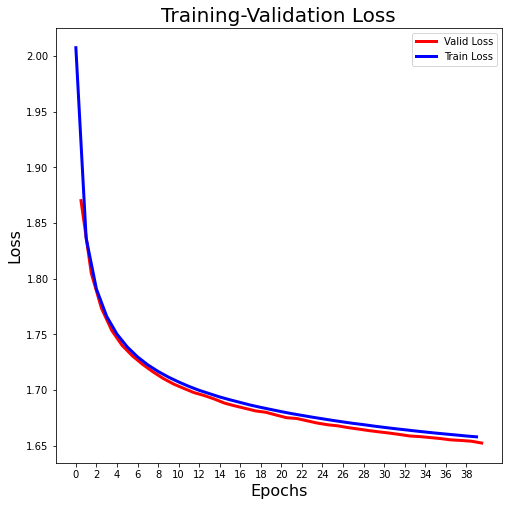

In [ ]:
history = nn_final.history

plt.figure(figsize = (8,8))
plt.plot(np.arange(0.5,max_epochs+0.5,1),history[:, 'valid_loss'], 'r',linewidth=3, label='Valid Loss')
plt.plot(np.arange(0,max_epochs),history[:, 'train_loss'], 'b',linewidth=3, label='Train Loss')
plt.title('Training-Validation Loss',fontsize=20)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.xticks(np.arange(0,max_epochs,2))
plt.legend()
plt.show()

In [ ]:
# Save network parameters
torch.save(net1.state_dict(), 'net1.pth')

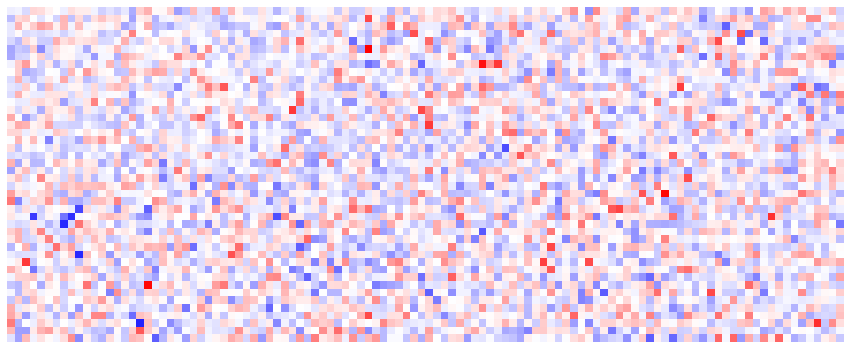

In [ ]:
Kx=5
Ky=2
draw_weights(net1.f2.weight.detach().numpy(), Kx, Ky, 22) 

# (Unfair) BackProp. Comparison

In [ ]:
class Net2(nn.Module):
    
    def __init__(self, Nh1, Nh2, Nh3):
        """
        Nh1 - Neurons in the input  layer
        Nh2 - Neurons in the hidden layer
        Nh3 - Neurons in the output layer
        """
        super().__init__()
        
        print('Network initialized')
        self.f0 = nn.Flatten()
        self.f1 = nn.Linear(in_features=Nh1,  out_features=Nh2)
        self.f2 = nn.Linear(in_features=Nh2,  out_features=Nh3)
        self.act = nn.Sigmoid()
        
    def forward(self, x, additional_out=False):
        x = self.f0(x)
        x = self.act(x)
        x = self.f1(x)
        x = self.act(x)
        x = self.f2(x)
        x = self.act(x)
        return x

In [ ]:
#---Initialize the network
torch.manual_seed(0)
Nh1 = neurons_input
Nh2 = neurons_output
Nh3 = num_classes
net2 = Net2(Nh1, Nh2, Nh3)

#---Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

net2.to(device) 

Network initialized
Training device: cpu


Net2(
  (f0): Flatten(start_dim=1, end_dim=-1)
  (f1): Linear(in_features=784, out_features=484, bias=True)
  (f2): Linear(in_features=484, out_features=10, bias=True)
  (act): Sigmoid()
)

In [ ]:
K_fold = 5
max_epochs = 2
nn_final2 = NeuralNetClassifier(module=net2, max_epochs=max_epochs, lr=0.005, 
                               train_split=ValidSplit(K_fold), optimizer=optim.Adam, criterion=torch.nn.CrossEntropyLoss,
                               iterator_train__shuffle=True)

c = nn_final2.get_iterator(train_dataloader.dataset)
nn_final2.fit(c.dataset,y=None)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9684       0.6798        1.7672  8.4920
      2        1.7026       0.8188        1.6577  8.2507


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net2(
    (f0): Flatten(start_dim=1, end_dim=-1)
    (f1): Linear(in_features=784, out_features=484, bias=True)
    (f2): Linear(in_features=484, out_features=10, bias=True)
    (act): Sigmoid()
  ),
)

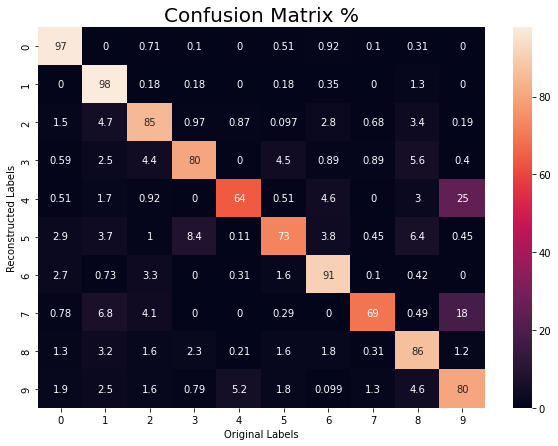

Final Test Accuray:  82.65 %


In [ ]:
d = nn_final2.get_iterator(test_dataloader.dataset)
y_pred = nn_final2.predict(d.dataset)
CM= confusion_matrix(d.dataset.targets.cpu().numpy(), y_pred, labels=np.arange(10))

plt.figure(figsize = (10,7))
cm = CM
cmn = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sn.heatmap(cmn, annot=True, xticklabels=np.arange(0,num_classes), yticklabels=np.arange(0,num_classes))
plt.title('Confusion Matrix %',fontsize=20)
plt.xlabel('Original Labels')
plt.ylabel('Reconstructed Labels')
plt.show()

print('Final Test Accuray: ',np.round(100*cm.diagonal().sum()/cm.sum(),2),'%')

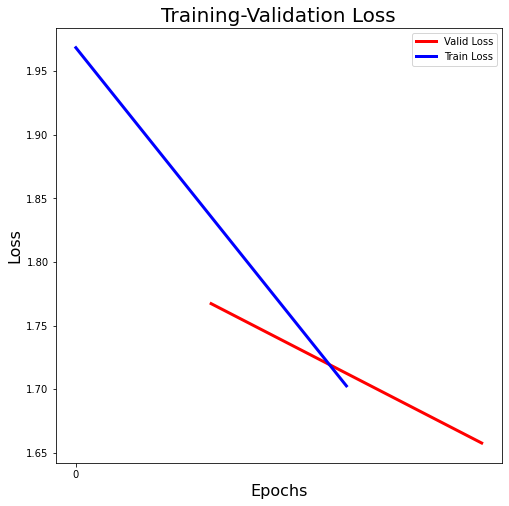

In [ ]:
history = nn_final2.history

plt.figure(figsize = (8,8))
plt.plot(np.arange(0.5,max_epochs+0.5,1),history[:, 'valid_loss'], 'r',linewidth=3, label='Valid Loss')
plt.plot(np.arange(0,max_epochs),history[:, 'train_loss'], 'b',linewidth=3, label='Train Loss')
plt.title('Training-Validation Loss',fontsize=20)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.xticks(np.arange(0,max_epochs,2))
plt.legend()
plt.show()

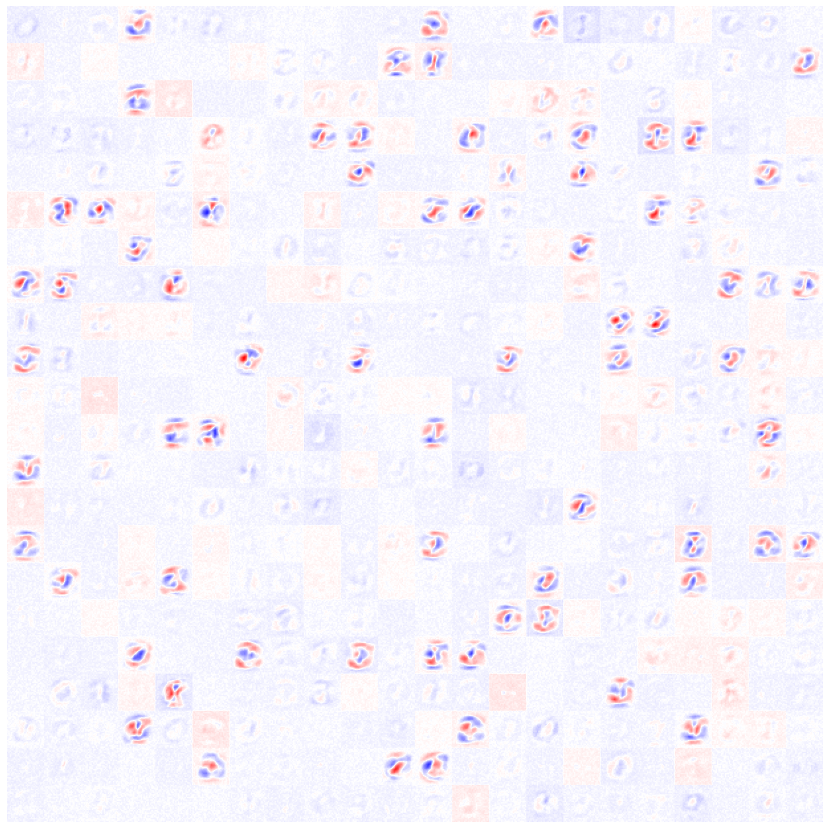

In [ ]:
draw_weights(net2.f1.weight.detach().numpy(), K, K, 28) 